In [1]:
%load_ext tensorboard

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Input, LeakyReLU, Reshape, Concatenate
import tensorflow_datasets as tfds
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.utils import plot_model
import pydot  
import cv2
import random

In [3]:
from sklearn import preprocessing

In [4]:
import pandas as pd

In [8]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kanitmann19bce2040","key":"c4125f5408b51277d12366896436e424"}'}

In [9]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [10]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [11]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27             67  
nickuzmenkov/ranzcr-clip-kfold-tfrecords                    RANZCR CLiP KFold TFRecords                         2GB  2021-02-21 13:29:51              6  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              215KB  2021-03-02 07:24:39              3  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44             19  
fatiimaezzahra/famous-iconic-women                          Famous Iconic Wo

In [21]:
! kaggle datasets download -d 'prajitdatta/movielens-100k-dataset'

movielens-100k-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [19]:
! mkdir train

In [23]:
! unzip movielens-100k-dataset.zip -d train

Archive:  movielens-100k-dataset.zip
  inflating: train/ml-100k/README    
  inflating: train/ml-100k/allbut.pl  
  inflating: train/ml-100k/mku.sh    
  inflating: train/ml-100k/u.data    
  inflating: train/ml-100k/u.genre   
  inflating: train/ml-100k/u.info    
  inflating: train/ml-100k/u.item    
  inflating: train/ml-100k/u.occupation  
  inflating: train/ml-100k/u.user    
  inflating: train/ml-100k/u1.base   
  inflating: train/ml-100k/u1.test   
  inflating: train/ml-100k/u2.base   
  inflating: train/ml-100k/u2.test   
  inflating: train/ml-100k/u3.base   
  inflating: train/ml-100k/u3.test   
  inflating: train/ml-100k/u4.base   
  inflating: train/ml-100k/u4.test   
  inflating: train/ml-100k/u5.base   
  inflating: train/ml-100k/u5.test   
  inflating: train/ml-100k/ua.base   
  inflating: train/ml-100k/ua.test   
  inflating: train/ml-100k/ub.base   
  inflating: train/ml-100k/ub.test   


In [25]:
columns_name=['user_id',"item_id","rating","timestamp"]
df=pd.read_csv("./train/ml-100k/u.data",sep='\t',names=columns_name)

In [26]:
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [27]:
df.shape

(100000, 4)

In [28]:
movies_title = pd.read_csv("./train/ml-100k/u.item", sep="\|",header= None,encoding='latin-1')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [30]:
movies_title=movies_title[[0,1]]
movies_title.columns=['item_id','title']
movies_title.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [31]:
df=pd.merge(df,movies_title,on="item_id")
df.tail()

,user_id,item_id,rating,timestamp,title
99995,840,1674,4,891211682,Mamma Roma (1962)
99996,655,1640,3,888474646,"Eighth Day, The (1996)"
99997,655,1637,3,888984255,Girls Town (1996)
99998,655,1630,3,887428735,"Silence of the Palace, The (Saimt el Qusur) (1..."
99999,655,1641,3,887427810,Dadetown (1995)


In [32]:
import seaborn as sns
sns.set_style('white')
df.groupby('title').mean()['rating'].sort_values(ascending=False)

title
Marlene Dietrich: Shadow and Light (1996)       5.0
Prefontaine (1997)                              5.0
Santa with Muscles (1996)                       5.0
Star Kid (1997)                                 5.0
Someone Else's America (1995)                   5.0
                                               ... 
Touki Bouki (Journey of the Hyena) (1973)       1.0
JLG/JLG - autoportrait de décembre (1994)       1.0
Daens (1992)                                    1.0
Butterfly Kiss (1995)                           1.0
Eye of Vichy, The (Oeil de Vichy, L') (1993)    1.0
Name: rating, Length: 1664, dtype: float64

In [33]:
ratings=pd.DataFrame(df.groupby('title').mean()['rating'])
ratings.head()

,rating
title,
'Til There Was You (1997),2.333333
1-900 (1994),2.600000
101 Dalmatians (1996),2.908257
12 Angry Men (1957),4.344000
187 (1997),3.024390


In [35]:
ratings['num of ratings']= pd.DataFrame(df.groupby('title').count()['rating'])
ratings

,rating,num of ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41
...,...,...
Young Guns II (1990),2.772727,44
"Young Poisoner's Handbook, The (1995)",3.341463,41
Zeus and Roxanne (1997),2.166667,6


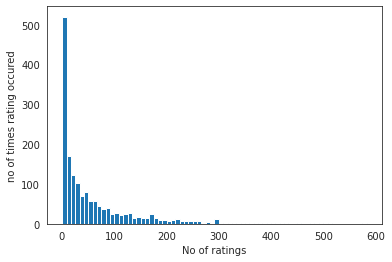

In [36]:
plt.hist(ratings['num of ratings'], bins=70)
plt.xlabel('No of ratings')
plt.ylabel('no of times rating occured')
plt.show()

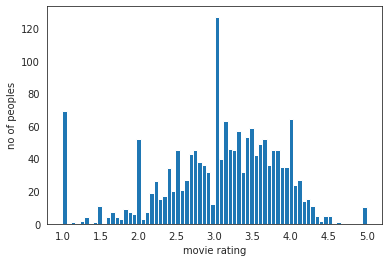

In [37]:
plt.hist(ratings['rating'],bins=70)
plt.xlabel('movie rating')
plt.ylabel('no of peoples')
plt.show()

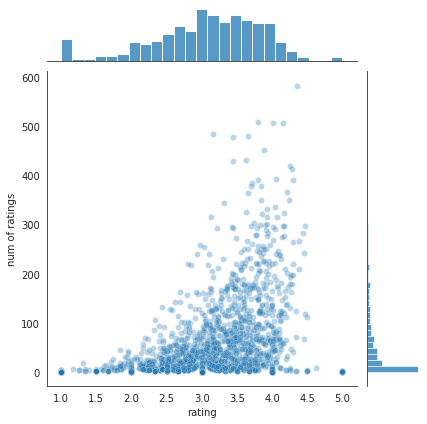

In [38]:
sns.jointplot(x='rating',y='num of ratings',data=ratings,alpha=0.3)

In [ ]:
class MovieDataset:
  def __init__(self,users,movies,ratings):
    self.users = users
    self.movies = movies
    self.ratings = ratings
  
  def __len__(self):
    return len(self.users)

  def __getitem__(self,item):
    user = self.users[item]
    movies = self.movies[item]
    rating = self.rating[item]
    return{"user":torch.tensor(user, dtyple = torch.long),
           "movies":torch.tensor(movies, dtyple = torch.long),
           "rating":torch.tensor(rating, dtyple = torch.float)
           }
  
  